In [54]:
# Traffic Model Retraining with Budget-Aware Scaling and Date Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [55]:
# Load your cleaned and encoded DataFrame
df = pd.read_csv("../data/meta_ads_cleaned.csv")
df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0281 - Campagne Ramadan - Instagram - ...,inactive,Instagram,In-app,Feed,Awareness,reach,0.28,Using ad set budget,0.28,...,0.000000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
1,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Feed,App Installs,actions:mobile_app_install,2.63,Using ad set budget,2.63,...,2.630000,0,0.0,0.00,0,0.0,0.000000,0,0.000000,0.00
2,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,Feed,Sales,actions:offsite_conversion.fb_pixel_purchase,22.80,Using ad set budget,22.80,...,0.000000,60,1199.0,0.38,730,1756.0,0.031233,228,0.100000,4.56
3,SO/2024/0318 - Campagne Ramadan 2 - BC : - In...,not_delivering,Audience Network,In-app,Facebook Stories,App Installs,actions:mobile_app_install,25.83,Using ad set budget,25.83,...,0.993462,0,0.0,0.00,3,0.0,8.610000,0,0.000000,0.00
4,SO/2024/0556 - Orange - Lancement_campagne_Dat...,not_delivering,Instagram,Desktop,Feed,Awareness,reach,191.10,Using ad set budget,191.10,...,0.000000,5,0.0,38.22,103,0.0,1.855340,32,5.971875,0.00


In [56]:
traffic_df = df[df['Objective'] == 'Traffic'].copy()
traffic_df.reset_index(drop=True, inplace=True)
traffic_df.head()

,Campaign name,Campaign Delivery,Platforme,Device,Placement,Objective,Result indicator,Ad set budget,Ad set budget type,Amount spent,...,Cost per app install (USD),Adds to cart,Adds to cart conversion value,Cost per add to cart (USD),Checkouts Initiated,Checkouts initiated conversion value,Cost per checkout initiated (USD),Landing page views,Cost per landing page view (USD),Cost per purchase (USD)
0,SO/2024/0884 - Orange - Lancement posts digita...,not_delivering,Instagram,Desktop,Feed,Traffic,actions:link_click,4505.81,Using ad set budget,4505.81,...,2.114411,243,71647.6,18.542428,3468,1788.29,1.299253,5850,0.770224,1501.936667
1,SO/2025/0206 Orange - Lancement posts digitaux...,active,Audience Network,Desktop,"Native, banner & interstitial",Traffic,actions:link_click,475.32,Using ad set budget,475.32,...,2.353069,111,249.0,4.282162,802,0.00,0.592668,13547,0.035087,475.320000
2,SO/2024/0582 - Orange - Campagne achat et rech...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,577.18,Using ad set budget,577.18,...,0.000000,14,0.0,41.227143,427,0.00,1.351710,2759,0.209199,577.180000
3,SO/2023/0333 - Orange - Campagne caravane Bal...,not_delivering,Facebook,In-app,Facebook Reels,Traffic,actions:link_click,368.26,Using ad set budget,368.26,...,0.000000,3,755.1,122.753333,23,0.00,16.011304,2,184.130000,0.000000
4,SO/2024/0576 - Orange - Lancement posts digita...,not_delivering,Audience Network,In-app,"Native, banner & interstitial",Traffic,actions:link_click,3006.70,Using ad set budget,3006.70,...,0.873279,1023,59950.0,2.939101,8444,277.50,0.356075,160516,0.018731,150.335000


In [57]:
categorical_cols = ['Platforme', 'Placement', 'Device', 'Ad set budget type']

traffic_df_encoded = pd.get_dummies(traffic_df, columns=categorical_cols, drop_first=True)

# --- Step 1.5: Add Date Features (if available)
if 'Starts' in traffic_df_encoded.columns:
    traffic_df_encoded['Starts'] = pd.to_datetime(traffic_df_encoded['Starts'])
    traffic_df_encoded['day'] = traffic_df_encoded['Starts'].dt.day
    traffic_df_encoded['month'] = traffic_df_encoded['Starts'].dt.month
    traffic_df_encoded['weekday'] = traffic_df_encoded['Starts'].dt.weekday
    traffic_df_encoded['year'] = traffic_df_encoded['Starts'].dt.year

In [58]:
# --- Step 1: Define Target Columns and Budget Unit ---
scale_unit = 300  # USD

In [59]:
# Avoid division by zero
traffic_df_encoded = traffic_df_encoded[traffic_df_encoded['Amount spent'] > 0]

In [60]:
# Create scaled targets (KPI per 1000 USD spent)
traffic_df_encoded['CTR'] = traffic_df_encoded['CTR (all)']
traffic_df_encoded['log_CTR'] = np.log1p(traffic_df_encoded['CTR'])
traffic_df_encoded['Clicks_scaled'] = traffic_df_encoded['Clicks (all)'] / (traffic_df_encoded['Amount spent'] / scale_unit)

In [61]:
# --- Step 2: Define Feature Set ---
target_cols = ['CTR_scaled', 'Clicks_scaled']
X = traffic_df_encoded.drop(columns=['CTR', 'CTR (all)', 'Clicks (all)', 'log_CTR', 'Clicks_scaled'])

# Drop non-numeric columns from X
non_numeric_cols = X.select_dtypes(include=['object', 'datetime64']).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", list(non_numeric_cols))
    X = X.drop(columns=non_numeric_cols)

Dropping non-numeric columns: ['Campaign name', 'Campaign Delivery', 'Objective', 'Result indicator', 'Attribution setting', 'Date created', 'Starts', 'Ends', 'Video average play time']


In [62]:
# --- Step 4: Split data ---
y_ctr = traffic_df_encoded['log_CTR']
y_clicks = traffic_df_encoded['Clicks_scaled']
X_train_ctr, X_test_ctr, y_train_ctr, y_test_ctr = train_test_split(X, y_ctr, test_size=0.2, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clicks, test_size=0.2, random_state=42)

In [63]:
print(X.select_dtypes(include='object').columns)

Index([], dtype='object')


In [86]:
# --- Step 5: Model candidates ---
ctr_models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=30000),
    "SVR": SVR(),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

click_models = {
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, random_state=42)
}

In [88]:
# --- Step 6: Train and evaluate CTR models ---
print("\n📈 CTR Model Comparison:")
ctr_results = []
best_ctr_model_name = None
best_ctr_r2 = -np.inf
for name, model in ctr_models.items():
    model.fit(X_train_ctr, y_train_ctr)
    preds = np.expm1(model.predict(X_test_ctr))
    actual = np.expm1(y_test_ctr)
    rmse = np.sqrt(mean_squared_error(actual, preds))
    r2 = r2_score(actual, preds)
    ctr_results.append((name, rmse, r2))
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")
    if r2 > best_ctr_r2:
        best_ctr_model_name = name
        best_ctr_r2 = r2


📈 CTR Model Comparison:
Ridge: RMSE = 0.68, R2 = 0.9209
Lasso: RMSE = 1.44, R2 = 0.6431
SVR: RMSE = 2.46, R2 = -0.0469
LinearRegression: RMSE = 0.94, R2 = 0.8491


C:\Users\ghass\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.413e-01, tolerance: 1.407e-03
  model = cd_fast.enet_coordinate_descent(


RandomForest: RMSE = 1.12, R2 = 0.7819
GradientBoosting: RMSE = 0.62, R2 = 0.9330


In [89]:
# --- Step 7: Train and evaluate Clicks models ---
print("\n📈 Clicks Model Comparison:")
click_results = []
best_click_model_name = None
best_click_r2 = -np.inf
for name, model in click_models.items():
    model.fit(X_train_c, y_train_c)
    preds = model.predict(X_test_c)
    rmse = np.sqrt(mean_squared_error(y_test_c, preds))
    r2 = r2_score(y_test_c, preds)
    click_results.append((name, rmse, r2))
    print(f"{name}: RMSE = {rmse:.2f}, R2 = {r2:.4f}")
    if r2 > best_click_r2:
        best_click_model_name = name
        best_click_r2 = r2


📈 Clicks Model Comparison:
Ridge: RMSE = 24437.69, R2 = 0.5904
RandomForest: RMSE = 18365.77, R2 = 0.7686
GradientBoosting: RMSE = 16494.57, R2 = 0.8134


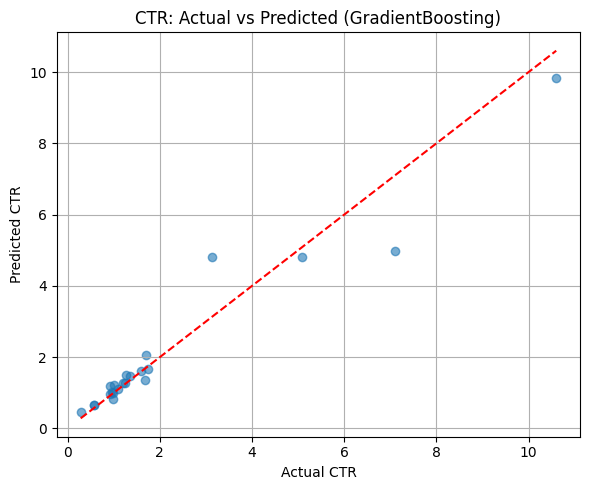

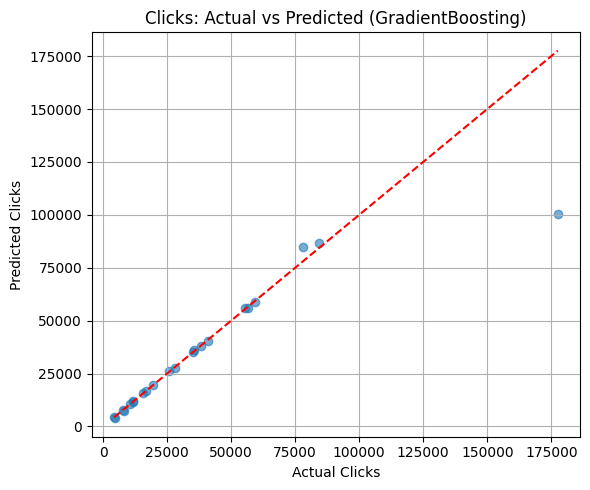

In [99]:
# --- Step 8: Visualize best models ---

# CTR Predictions
ctr_preds_best = np.expm1(ctr_models[best_ctr_model_name].predict(X_test_ctr))
true_ctr = np.expm1(y_test_ctr)

plt.figure(figsize=(6, 5))
plt.scatter(true_ctr, ctr_preds_best, alpha=0.6)
plt.plot([true_ctr.min(), true_ctr.max()], [true_ctr.min(), true_ctr.max()], 'r--')
plt.xlabel("Actual CTR")
plt.ylabel("Predicted CTR")
plt.title(f"CTR: Actual vs Predicted ({best_ctr_model_name})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Clicks Predictions
click_preds_best = click_models[best_click_model_name].predict(X_test_c)

plt.figure(figsize=(6, 5))
plt.scatter(y_test_c, click_preds_best, alpha=0.6)
plt.plot([y_test_c.min(), y_test_c.max()], [y_test_c.min(), y_test_c.max()], 'r--')
plt.xlabel("Actual Clicks")
plt.ylabel("Predicted Clicks")
plt.title(f"Clicks: Actual vs Predicted ({best_click_model_name})")
plt.grid(True)
plt.tight_layout()
plt.show()

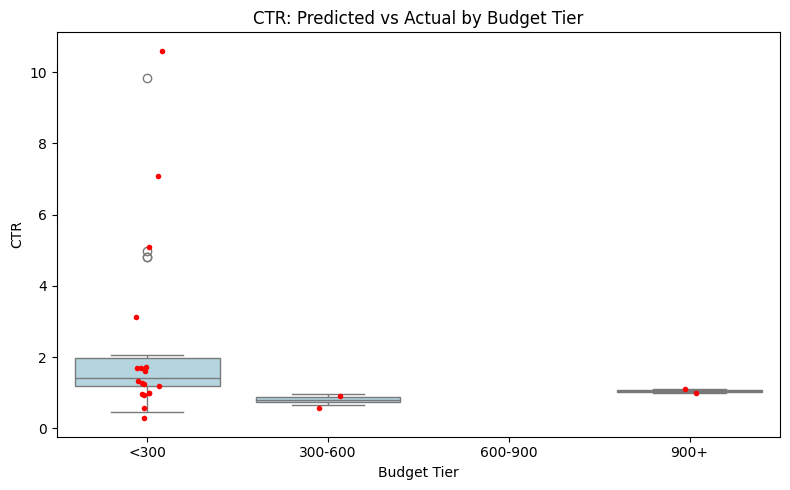

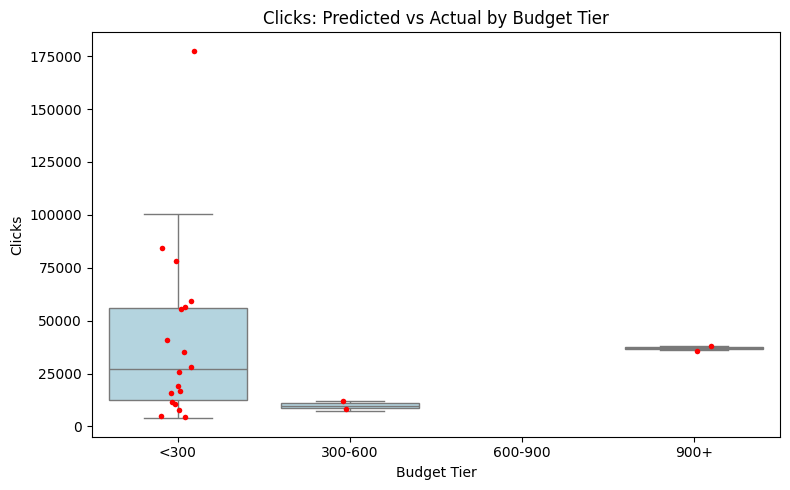

In [107]:
# --- Step 8.5: Budget Tier Visualizations ---

# Prepare budget tiers
df['Amount spent'] = df['Amount spent'].astype(float)
df['tier'] = pd.cut(df['Amount spent'], bins=[0, 300, 600, 900, np.inf], labels=['<300', '300-600', '600-900', '900+'])

# CTR tier comparison
tier_df_ctr = X_test_ctr.copy()
tier_df_ctr['Actual_CTR'] = true_ctr
tier_df_ctr['Predicted_CTR'] = ctr_preds_best
tier_df_ctr['Amount spent'] = df.loc[X_test_ctr.index, 'Amount spent']
tier_df_ctr['tier'] = pd.cut(tier_df_ctr['Amount spent'], bins=[0, 300, 600, 900, np.inf], labels=['<300', '300-600', '600-900', '900+'])
plt.figure(figsize=(8, 5))
sns.boxplot(data=tier_df_ctr, x='tier', y='Predicted_CTR', color='lightblue')
sns.stripplot(data=tier_df_ctr, x='tier', y='Actual_CTR', color='red', size=4, jitter=True)
plt.title("CTR: Predicted vs Actual by Budget Tier")
plt.ylabel("CTR")
plt.xlabel("Budget Tier")
plt.tight_layout()
plt.show()

# Clicks tier comparison
tier_df_clicks = X_test_c.copy()
tier_df_clicks['Actual_Clicks'] = y_test_c
tier_df_clicks['Predicted_Clicks'] = click_preds_best
tier_df_clicks['Amount spent'] = df.loc[X_test_c.index, 'Amount spent']
tier_df_clicks['tier'] = pd.cut(tier_df_clicks['Amount spent'], bins=[0, 300, 600, 900, np.inf], labels=['<300', '300-600', '600-900', '900+'])

plt.figure(figsize=(8, 5))
sns.boxplot(data=tier_df_clicks, x='tier', y='Predicted_Clicks', color='lightblue')
sns.stripplot(data=tier_df_clicks, x='tier', y='Actual_Clicks', color='red', size=4, jitter=True)
plt.title("Clicks: Predicted vs Actual by Budget Tier")
plt.ylabel("Clicks")
plt.xlabel("Budget Tier")
plt.tight_layout()
plt.show()

In [108]:
# --- Step 9: Save best models based on evaluation ---
print(f"\n✅ Best CTR model: {best_ctr_model_name}")
print(f"✅ Best Clicks model: {best_click_model_name}")

ctr_model_to_save = ctr_models[best_ctr_model_name]
ctr_model_to_save.fit(X_train_ctr, y_train_ctr)
joblib.dump(ctr_model_to_save, 'ctr_model.pkl')

click_model_to_save = click_models[best_click_model_name]
click_model_to_save.fit(X_train_c, y_train_c)
joblib.dump(click_model_to_save, 'clicks_model.pkl')

joblib.dump(list(X.columns), 'traffic_model_features.pkl')

print("\n✅ Best CTR and Clicks models saved based on top R² performance.")


✅ Best CTR model: GradientBoosting
✅ Best Clicks model: GradientBoosting

✅ Best CTR and Clicks models saved based on top R² performance.
